# [AI502] Programming Assignment 2
_student id: 20233359, name: Junyeob Baek_

In [1]:
!pip install EMD-signal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 KB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 36.4 MB/s eta 0:00:00
  Using cached scipy-1.10.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 51.7 MB/s eta 0:00:00
You should consider upgrading via the '/home/junyeob/.pyenv/versions/3.9.16/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## Synthetic time series example
Suppose a simple regression problem.

$$f(t) = \sin(0.01t) + 0.2 \epsilon, \quad \epsilon\sim\mathcal{N}(0,1), \quad t\in [0,1000]$$

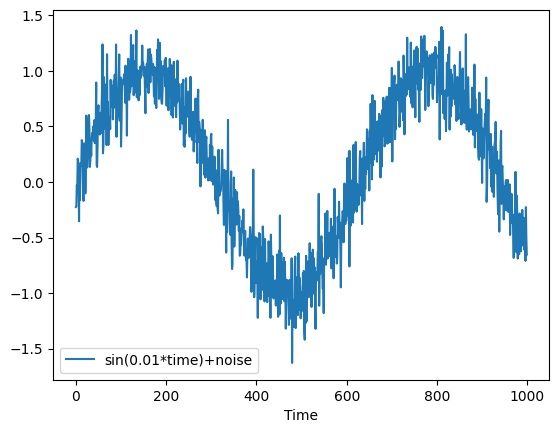

In [3]:
T = 1000
time = torch.arange(0.0, T)
X = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
plt.plot(time.numpy(), X.numpy(), label="sin(0.01*time)+noise");
plt.legend();
plt.xlabel("Time");
plt.show()

## Extract Intrinsic Mode Functions(IMFs) using EMD module

/tmp/ipykernel_3299207/874794362.py:14: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


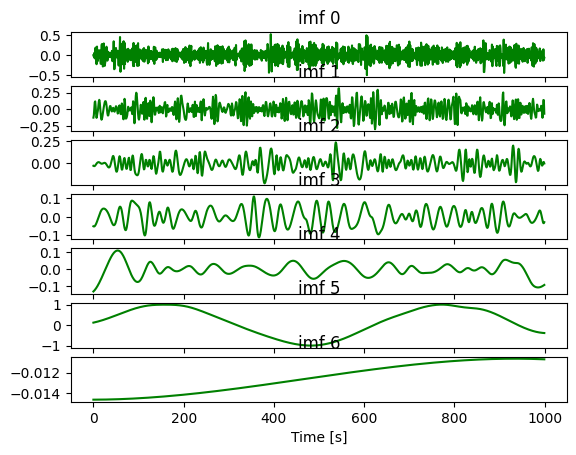

In [4]:
from PyEMD import EMD

# Execute EMD on inputs(regard the inputs as seasonal data)
emd = EMD()
imfs = emd(X.numpy())
N = imfs.shape[0]

# Plot results
for n, imf in enumerate(imfs):
    plt.subplot(N, 1, n+1)
    plt.plot(np.arange(len(X)), imf, 'g')
    plt.title("imf "+str(n))
    plt.xlabel("Time [s]")
plt.tight_layout()

# Build My Own RNN

In [5]:
class MyRNN(nn.Module):
    def __init__(self, num_imfs, hidden_dim=10, tau=4):
        super(MyRNN, self).__init__()
        self.num_rnn = num_imfs
        self.hidden_dim = hidden_dim
        self.tau = tau
        
        self.rnns = [nn.RNN(1, hidden_dim, batch_first=True) for _ in range(num_imfs)]
        self.relu = nn.ReLU()
        self.linears = [nn.Linear(hidden_dim, 1) for _ in range(num_imfs)]
        self.fc = nn.Linear(hidden_dim*num_imfs, 1)

    def forward(self, inputs):
        # inputs[0]: original, inputs[1:]: intrinsic mode funcitons
        outputs = []
        for i in range(1, self.num_rnn + 1):
            out, hidden = self.rnns[i-1](inputs[:, i])      
            outputs.append(out[:, -1, :])
        
        # predict next imfs
        imfs = torch.concat([self.linears[i](self.relu(outputs[i])) for i in range(self.num_rnn)], dim=-1)
        # predict next output
        outputs = torch.concat(outputs, dim=-1)
        outputs = self.fc(self.relu(outputs))
        
        return torch.concat([outputs, imfs], dim=-1)

In [6]:
# Hyperparameter
batch_size, train_number = 16, 600

# timestamp
tau = 10
features = torch.zeros((T-tau, N+1, tau, 1)) # RNN Model needs tau inputs: shape is (996, N+1, tau, 1)
for i in range(tau):
    features[:, 0, i] = torch.Tensor(X[i:(T-tau + i)]).unsqueeze(-1) # original data
    for n in range(N):
        features[:, n, i] = torch.Tensor(imfs[n, i:(T-tau + i)]).unsqueeze(-1) # intrinsic mode funtion data
    
labels = torch.concat([X[tau:].reshape(-1,1), torch.Tensor(imfs[:, tau:]).reshape(-1,N)], dim=-1) # shape is (996, N+1, 1)

# Prepare DataLoader
train_data = TensorDataset(features[:train_number], labels[:train_number])
test_data = TensorDataset(features[train_number:], labels[train_number:])

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam

def train_net(net, data, criterion, epochs, lr_rate):
    optim = optimizer(net.parameters(), lr=lr_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.95)
    data_iter = DataLoader(data, batch_size, shuffle=True)

    losses = []
    for epoch in range(1, epochs+1):
        running_loss = 0.0
        
        for x, y in data_iter:
            optim.zero_grad()
            output = net(x)
            loss = criterion(output, y)
            loss.backward()
            optim.step()
            running_loss += loss.item()
        scheduler.step()
        
        print("epoch: {}, loss: {:.2f}, lr:{:.5f}".format(epoch, running_loss, scheduler.get_lr()[-1]))
        losses.append(running_loss)
    plt.plot(np.arange(epochs), losses, label='Loss')
    plt.legend()
    plt.show()
    test_loss = criterion(net(test_data[:][0]), test_data[:][1])
    print('test loss: %f' % test_loss.mean().detach().numpy())
    
    
    return net

# Train My RNN

/home/junyeob/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


epoch: 1, loss: 2.88, lr:0.03000
epoch: 2, loss: 1.66, lr:0.03000
epoch: 3, loss: 1.48, lr:0.03000
epoch: 4, loss: 1.47, lr:0.03000
epoch: 5, loss: 1.50, lr:0.02707
epoch: 6, loss: 1.48, lr:0.02850
epoch: 7, loss: 1.46, lr:0.02850
epoch: 8, loss: 1.45, lr:0.02850
epoch: 9, loss: 1.46, lr:0.02850
epoch: 10, loss: 1.47, lr:0.02572
epoch: 11, loss: 1.45, lr:0.02707
epoch: 12, loss: 1.46, lr:0.02707
epoch: 13, loss: 1.45, lr:0.02707
epoch: 14, loss: 1.46, lr:0.02707
epoch: 15, loss: 1.46, lr:0.02444
epoch: 16, loss: 1.45, lr:0.02572
epoch: 17, loss: 1.44, lr:0.02572
epoch: 18, loss: 1.48, lr:0.02572
epoch: 19, loss: 1.45, lr:0.02572
epoch: 20, loss: 1.44, lr:0.02321
epoch: 21, loss: 1.44, lr:0.02444
epoch: 22, loss: 1.45, lr:0.02444
epoch: 23, loss: 1.44, lr:0.02444
epoch: 24, loss: 1.45, lr:0.02444
epoch: 25, loss: 1.44, lr:0.02205
epoch: 26, loss: 1.44, lr:0.02321
epoch: 27, loss: 1.45, lr:0.02321
epoch: 28, loss: 1.45, lr:0.02321
epoch: 29, loss: 1.45, lr:0.02321
epoch: 30, loss: 1.45, 

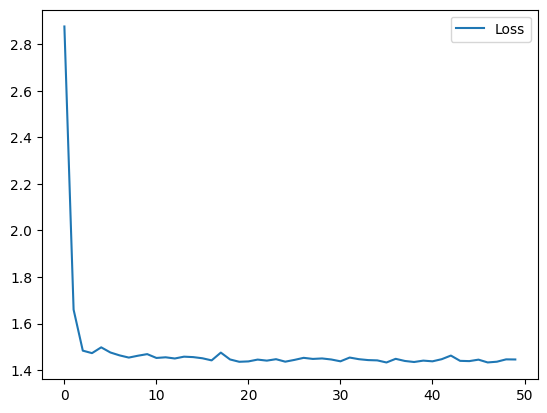

test loss: 0.179741


In [8]:
my_net = MyRNN(num_imfs=N)
my_net = train_net(my_net, train_data, criterion, 50, 0.03)

# Test My RNN(do not touch this part)

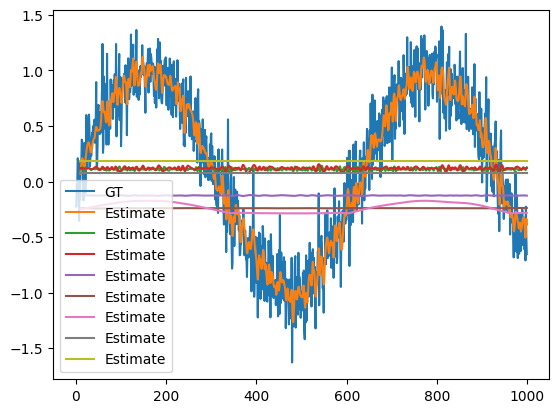

train loss: 0.03749014809727669
test loss: 0.17624269425868988


In [9]:
my_estimates = my_net(features)
plt.plot(time.numpy(), X.numpy(), label='GT')
plt.plot(time[tau:].numpy(), my_estimates.detach().numpy(), label='Estimate')
plt.legend()
plt.show()

my_train_estimate_loss = criterion(my_estimates[:train_number-tau].squeeze(), labels[:train_number-tau]).item()
my_test_estimate_loss = criterion(my_estimates[train_number-tau:].squeeze(), labels[train_number-tau:]).item()
print('train loss:', my_train_estimate_loss)
print('test loss:', my_test_estimate_loss)

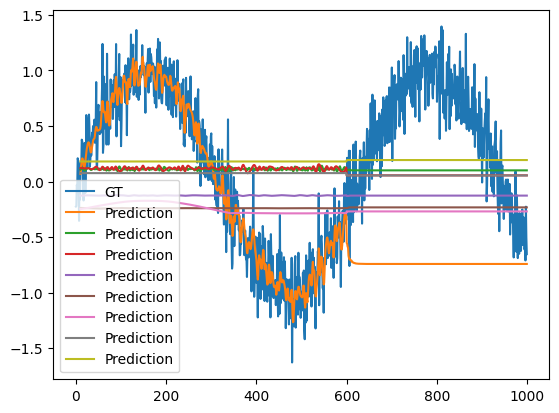

train loss: 0.03749014809727669
test loss: 0.3821728229522705


In [10]:
my_predictions = torch.zeros_like(my_estimates)
my_predictions[:(train_number - tau)] = my_estimates[:(train_number - tau)]

for i in range((train_number - tau), (T - tau)):
    my_predictions[i] = my_net(
        my_predictions[(i - tau):i].reshape(1, -1, tau, 1)
    )

plt.plot(time.numpy(), X.numpy(), label='GT')
plt.plot(time[tau:].numpy(), my_predictions.detach().numpy(), label='Prediction')
plt.legend()
plt.show()

my_train_prediction_loss = criterion(my_predictions[:train_number-tau].squeeze(), labels[:train_number-tau]).item()
my_test_prediction_loss = criterion(my_predictions[train_number-tau:].squeeze(), labels[train_number-tau:]).item()
print('train loss:', my_train_prediction_loss)
print('test loss:', my_test_prediction_loss)